In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

## Boundary

In [96]:
nf = 18
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [97]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 70

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='MQ')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

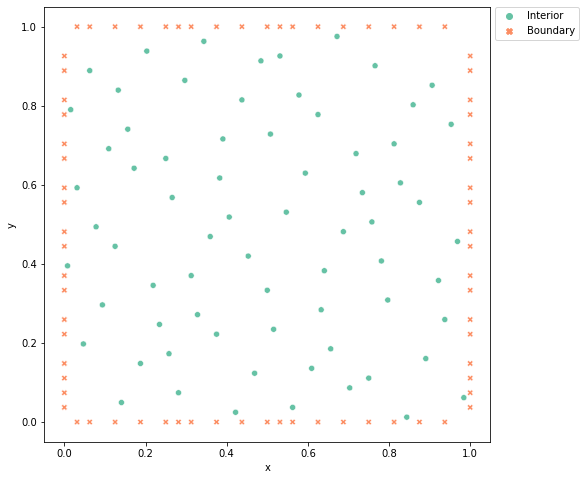

In [98]:
points = pd.concat([interior_points, boundary_points])
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation', style='Collocation', palette='Set2')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [14]:
A = uh.A()
dimA = A.shape[0]

In [16]:
A

array([[ 1.        ,  2.82842712,  1.58796296,  2.20567236,  0.66666667,
         0.        ,  0.        ],
       [ 2.82842712,  1.        ,  1.58796296,  2.20567236,  0.66666667,
         1.33333333, -3.11111111],
       [ 1.58796296,  1.58796296,  1.        ,  2.82842712,  0.        ,
         0.        , -2.        ],
       [ 2.20567236,  2.20567236,  2.82842712,  1.        ,  2.        ,
         2.        ,  2.        ],
       [ 0.66666667,  0.66666667,  0.        ,  2.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.33333333,  0.        ,  2.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -3.11111111, -2.        ,  2.        ,  0.        ,
         0.        ,  0.        ]])

In [21]:
lamb = 0.25
pinvA = np.matmul(np.linalg.inv(np.matmul(A, A.T) + lamb**2 * np.eye(dimA)), A.T)
Aprime=np.linalg.inv(pinvA)
print("A determinant: {} \nA' determinant: {}".format(np.linalg.det(A), np.linalg.det(Aprime)))

A determinant: -10.119650202190767 
A' determinant: -92.83404474143872


In [99]:
uh.Mi = np.random.random((npnts, 2))
k1 = uh.K1()
m= uh.M()

q1 = uh.Q1()
k2 = uh.K2()
q2 = uh.Q2()
o2 = uh.O2()

K = np.vstack((np.hstack((k1, m, q1)), np.hstack((m.T, k2, q2)), np.hstack((q1.T, q2.T, o2))))
A = np.vstack((np.hstack((k2, q2)), np.hstack((q2.T, o2))))

lamb = 0.1
dimK = K.shape[0]
pinvK = np.matmul(np.linalg.inv(np.matmul(K, K.T) + lamb**2 * np.eye(dimK)), K.T)
Kprime=np.linalg.inv(pinvK)
_, s, __ = np.linalg.svd(K)
_, sp, __ = np.linalg.svd(Kprime)
print('Condition Number K: {:,.2f}'.format(max(s)/min(s)))
print('Condition Number K prime: {:,.2f}'.format(max(sp)/min(sp)))
print('Determinant K: {:,.2f}'.format(np.linalg.det(K)))
print('Determinant K prime: {:,.2f}'.format(np.linalg.det(Kprime)))
np.mean(K-Kprime)

Condition Number K: 31,498,192,565,211,924.00
Condition Number K prime: 378,547,413,855,657.75
Determinant K: -0.00
Determinant K prime: -inf


d:\projects\MSc Thesis\.env\lib\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


7.028840526530916e-07

In [101]:
def set_lamb(K, n, m):
    lambd_ops = np.linspace(0, m, int(m*n)+1)
    data = list()
    for l in lambd_ops:
        dimK = K.shape[0]
        pinvK = np.matmul(np.linalg.inv(
            np.matmul(K, K.T) + l**2 * np.eye(dimK)), K.T)
        Kprime = np.linalg.inv(pinvK)
        _, s, __ = np.linalg.svd(K)
        _, sp, __ = np.linalg.svd(Kprime)
        cnK = max(s)/min(s)
        cnKprime = max(sp)/min(sp)
        detK = np.linalg.det(K)
        detKprime = np.linalg.det(Kprime)
        error = np.mean(abs(K-Kprime))
        data.append({'lambda': l, 'cond_num_K': cnK,
                     'cond_num_K_prime': cnKprime, 'det_K': detK, 'det_K_prime': detKprime, 'Error': error})
        # print('Condition Number K: {:,.2f}'.format(max(s)/min(s)))
        # print('Condition Number K prime: {:,.2f}'.format(max(sp)/min(sp)))
        # print('Determinant K: {:,.2f}'.format(np.linalg.det(K)))
        # print('Determinant K prime: {:,.2f}'.format(np.linalg.det(Kprime)))
    return data


In [102]:
df_lambda = pd.DataFrame(set_lamb(K, 10000, 1))

<AxesSubplot:xlabel='lambda', ylabel='cond_num_K_prime'>

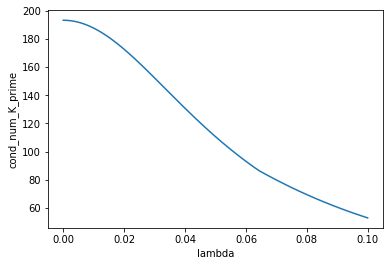

In [92]:
sns.lineplot(data = df_lambda, x='lambda', y='cond_num_K_prime')

In [93]:
min_cond_num = df_lambda['cond_num_K_prime'].min()
df_lambda.loc[df_lambda['cond_num_K_prime'] == min_cond_num]

,lambda,cond_num_K,cond_num_K_prime,det_K,det_K_prime,Error
1000,0.1,193.395412,52.879199,0.38641,5.332616,0.016268


In [94]:
np.mean(K)

0.8641456151962755

<AxesSubplot:xlabel='lambda', ylabel='Error'>

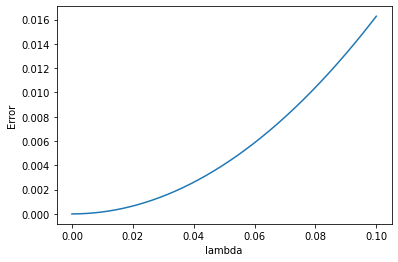

In [95]:
sns.lineplot(data = df_lambda, x='lambda', y='Error')

In [ ]:
t0, te = 0, 0.5
N = 20
uh.alpha = 0.8
X0 = uh.X_0()
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [ ]:
X0

In [ ]:
exp_RK.solve()

In [ ]:
exp_RK.solution[1]

In [ ]:
np.linspace(t0, te,N+1)

In [ ]:
X0 + 0.025*Fm(0.025, X0, uh) - exp_RK.solution[1]

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 0.025)
abs(ex - exp_RK.solution[3])/ex * 100
ex

In [ ]:
for k,i in enumerate(np.linspace(0,1,N+1)):
    if k%20==0:
        print("{:,.0f}. {:,.4f}".format(k, i))


In [ ]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for _ in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='v', data=dff)
    return df

def u(Mi, norm_x, t, alpha=0.8):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 1.)
abs(ex - exp_RK.solution[40])/ex * 100
ex

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
L, H = np.pi*np.mgrid[-1:1:1000j, -1:1:1000j]
T = np.cos(L)*np.cos(2*H)
H = np.cos(L) + H
fig, ax = plt.subplots()
surf = plt.contourf(L, H, T, cmap="hot")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
L, H = np.pi*np.mgrid[-1:1:10j, -1:1:10j]
L

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')